In [ ]:
from keras.models import Model
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, LeakyReLU, Input, Add
from keras.initializers import RandomNormal
from keras.optimizers import Adam

import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

Using TensorFlow backend.


In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

In [ ]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

Let's define a discriminator which will have 4 Convolutional layers and one output layer. As the activation functions we will use the LeakyReLU. This is a simple architecture which we have used before. For GAN's we want to train our discriminator more than the generator, we can do this by passing a loss_weights parameter when compiling our model. This will divide the loss for the discriminator in half during training, which will slow down updates to the discriminator relative to the generator.

In [ ]:
def define_discriminator(image_shape=(256, 256, 3)):
	init = RandomNormal(stddev=0.02)
	inp = Input(shape=image_shape)

	d = Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(inp)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU()(d)

	d = Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU()(d)
 
	d = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU()(d)

	patch_out = Conv2D(1, (4, 4), padding='same', kernel_initializer=init)(d)

	model = Model(inp, patch_out)
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
  
	return model

Next step is to create a generator model. It will consist of a couple of convolutional blocks that will downsample and encode the image, couple of residual network blocks to transform the image and a number of upsampling convolutional blocks to generate the output image. Before creatign the Generator we will define the resnet block.

In [ ]:
def define_resnet(inp):
  init = RandomNormal(stddev=0.02)
  r = Conv2D(256, (3, 3), padding='same', kernel_initializer=init)(inp)
  r = BatchNormalization()(r)
  r = Activation('relu')(r)

  r = Conv2D(256, (3, 3), padding='same', kernel_initializer=init)(r)
  r = BatchNormalization()(r)

  r = Add()([r, inp])
  return r

Next we define a function which creates 9-resnet block version for 256x256 input images.

The model will output pixel values with shapes as the input and pixel values are in the range [-1, 1].

In [ ]:
def define_generator(img_shape=(256, 256, 3), resnet=6):
  init = RandomNormal(stddev=0.03)
  inp = Input(shape=img_shape)

  c = Conv2D(64, (7, 7), padding='same', kernel_initializer=init)(inp)
  c = InstanceNormalization(axis=-1)(c)
  c = Activation('relu')(c)

  c = Conv2D(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init)(c)
  c = InstanceNormalization(axis=-1)(c)
  c = Activation('relu')(c)

  c = Conv2D(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init)(c)
  c = InstanceNormalization(axis=-1)(c)
  c = Activation('relu')(c)

  # Resnet part
  for i in range(resnet):
    c = define_resnet(c)
  
  c = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init)(c)
  c = InstanceNormalization(axis=-1)(c)
  c = Activation('relu')(c)

  c = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init)(c)
  c = InstanceNormalization(axis=-1)(c)
  c = Activation('relu')(c)

  c = Conv2DTranspose(3, (7, 7), padding='same', kernel_initializer=init)(c)
  c = InstanceNormalization(axis=-1)(c)
  out = Activation('tanh')(c)

  model = Model(inp, out)
  return model

We are not updatitng the generator model weights directly but we do that by using the composite models.


Now we will create a function to define the composite model. 

1) A composite model is required for each generator model that is responsible for only updating the weights of that generator model. This can be achieved by marking the weights of the other models as not trainable.

2) Now we will pass a real image from the source domain through the generator model and connect the output of the generator to the discriminator which will classify as real or fake.

3) Next we will connect the identity mapping element with a new input for the real image from the target domain which will be passed through the generator and it will output a untranslated image.

We now add the forward and backward cycles. 

4) The forward cycle can be achieved by connecting the output of our generator to the other generator. This output can be compared to the input our generator and should be almost the same.

5) The backward cycle involved the input for the real image from the target domain passing through the other generator, then passing through our generator. This should match the real image from the target domain.

6) The last step is to create our model with two inputs(one real image for the source and the target domain) and four outputs (For the discriminator, one for the generator for the identitiy mapping, one for the other generator for the forward cycle and one from our generator for the backward cycle.

7) The adverserial loss for the discriminator output uses least square loss which is the mean squared error (mse). The outputs from the generator are compared to images and are optimized using the mean absolute error (mae).

The generator is updated as a weighted average of the four losses. This can be done using the loss_weights parameter when compiling our model. The adverserial loss is weighted normally, whereas the forward and backward loss is weighted more. It can be said that it is 10 times more important than the adverserial loss. The identity loss will be set to 5.

In [ ]:
def define_composite(g_model_1, d_model, g_model_2, img_shape=(256, 256, 3)):
  g_model_1.trainable = True
  d_model.trainable = False
  g_model_2.trainable = False

  # 2.
  input_gen = Input(shape=img_shape)
  gen1_out = g_model_1(input_gen)
  out_d = d_model(gen1_out)

  # 3.
  input_id = Input(shape=img_shape)
  out_id = g_model_1(input_id)

  # 4.
  out_f = g_model_2(gen1_out)

  # 5.
  gen2_out = g_model_2(input_id)
  out_b = g_model_1(gen2_out)

  # 6.
  model = Model([input_gen, input_id], [out_d, out_id, out_f, out_b])

  # 7.
  model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=Adam(lr=0.0002, beta_1=0.5))
  return model

We are going to first define our two generators and two discriminators.

In [ ]:
g_A_B = define_generator()
g_B_A = define_generator()
d_A = define_discriminator()
d_B = define_discriminator()

We can now define our two composite models for training the both generator models.

In [ ]:
c_A_B_A = define_composite(g_A_B, d_B, g_B_A)
c_B_A_B = define_composite(g_B_A, d_A, g_A_B)

Now we can train our models. Let's define a function that will get our real samples and our fake samples.

In [ ]:
def generate_real(dataset, n_samples, patch_shape):
  ix = np.random.randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]

  y = np.ones((n_samples, patch_shape, patch_shape, 1))
  return X, y

In [ ]:
def generate_fake(g, dataset, patch_shape):
  X = g.predict(dataset)

  y = np.zeros((len(X), patch_shape, patch_shape, 1))
  return X, y

The real paper described using a pool of previously generated images from which examples are randomly selected and used to update the discirminator model

In [ ]:
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:

			pool.append(image)
			selected.append(image)
		elif np.random.random() < 0.5:

			selected.append(image)
		else:

			ix = np.random.randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return np.asarray(selected)

Now we define a train function. We will gather real and fake data and train the model as described earlier.

In [ ]:
def train(d_A, d_B, g_A_B, g_B_A, c_A_B_A, c_B_A_B, dataset):
  n_epochs = 100
  n_batch = 1

  n_patch = d_A.output_shape[1]
  
  trainA, trainB = dataset
  poolA, poolB = list(), list()
  print("Starting training!")
  for i in range(n_epochs):
    start = time.time()
    x_real_A, y_real_A = generate_real(trainA, n_batch, n_patch)
    x_real_B, y_real_B = generate_real(trainB, n_batch, n_patch)

    x_fake_A, y_fake_A = generate_fake(g_B_A, x_real_B, n_patch)
    x_fake_B, y_fake_B = generate_fake(g_A_B, x_real_A, n_patch)
    
    x_fake_A = update_image_pool(poolA, x_fake_A)
    x_fake_B = update_image_pool(poolB, x_fake_B)
  
    g_loss2, _, _, _, _ = c_B_A_B.train_on_batch([x_real_B, x_real_A], [y_real_A, x_real_A, x_real_B, x_real_A])
    d_A_loss1 = d_A.train_on_batch(x_real_A, y_real_A)
    d_A_loss2 = d_A.train_on_batch(x_fake_A, y_fake_A)

    g_loss1, _, _, _, _ = c_A_B_A.train_on_batch([x_real_A, x_real_B], [y_real_B, x_real_B, x_real_A, x_real_B])
    d_B_loss1 = d_B.train_on_batch(x_real_B, y_real_B)
    d_B_loss2 = d_B.train_on_batch(x_fake_B, y_fake_B)

    print(f"Epoch: {i+1}, time needed for epoch: {time.time() - start}")

Let's download our dataset using the code bellow.

In [ ]:
!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/monet2photo.zip
!unzip "monet2photo.zip"

We are going to define two helper function. One is for normalizing our data and the second one for loading it.

In [ ]:
def normalize_arr(arr):
  arr = arr / 127.5 - 1
  return arr

def load_dataset(image_list, image_path):
  img_array = []
  for img_name in image_list:
    image = np.array(Image.open(os.path.join(image_path, img_name)))

    image = normalize_arr(image)
    img_array.append(image)
  
  return np.array(img_array)

The trainA and trainB consist of 1000 images, each with the size of (256, 256, 3).

In [ ]:
dir = "monet2photo/"

trainA_path = os.path.join(dir, "trainA")
trainA_images = os.listdir(trainA_path)
trainA_images = trainA_images[:1000]


trainB_path = os.path.join(dir, "trainB")
trainB_images = os.listdir(trainB_path)
trainB_images = trainB_images[:1000]

trainA = load_dataset(trainA_images, trainA_path)
trainB = load_dataset(trainB_images, trainB_path)

We combine trainA and trainB into one big dataset. It consists of two datasets each having 1000 pictures of the shape 256x256x3.

In [ ]:
dataset = [trainA, trainB]

We pass it into our training function and let it train. We are only training it for a small number of epochs.

In [ ]:
train(d_A, d_B, g_A_B, g_B_A, c_A_B_A, c_B_A_B, dataset)

Time for testing the generator. We are going to load two testing datasets, testA and testB, the same way we loaded the training datasets.

In [ ]:
test_path = os.path.join(dir, "testB")
test_images = os.listdir(test_path)
test_images = test_images[:20]

test= load_dataset(test_images, test_path)

Predict the images using the generator from that transforms images from B to A and use it on the testB dataset.

In [ ]:
images = g_B_A.predict(test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

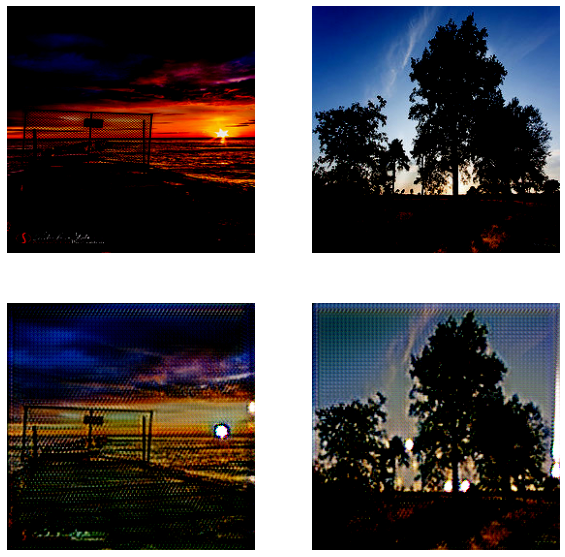

In [ ]:
fig = plt.figure(figsize=(10, 10))

ax0 = fig.add_subplot(2, 2, 1)
ax0.imshow(test[2])
ax0.axis('off')

ax1 = fig.add_subplot(2, 2, 2)
ax1.imshow(test[3])
ax1.axis('off')

ax2 = fig.add_subplot(2, 2, 3)
ax2.imshow(images[2])
ax2.axis('off')

ax3 = fig.add_subplot(2, 2, 4)
ax3.imshow(images[3])
ax3.axis('off')